# Import des bibliothèques et du dataset

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, StandardScaler
from category_encoders import TargetEncoder

from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyRegressor
from scipy.stats import f_oneway
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import time
import shap

import category_encoders as ce
import missingno as msno
import seaborn as sns

In [2]:
df = pd.read_csv('/kaggle/input/projet3-dataset/data.csv', sep=',')
df.head()

pd.set_option('display.max_columns', None)

# Nettoyage des données

In [3]:
df.shape

(3376, 46)

In [4]:
df = df[df['Outlier'].isna()]

values_to_remove = ['Error - Correct Default Data', 'Missing Data']
df = df[~df['ComplianceStatus'].isin(values_to_remove)]

df = df.dropna(subset=['NumberofBuildings'])
df = df.dropna(subset=['SiteEnergyUseWN(kBtu)'])
df = df.dropna(subset=['SiteEUI(kBtu/sf)'])

df = df[df['OSEBuildingID'] != 496]
df = df[df['OSEBuildingID'] != 49784]
df = df[df['OSEBuildingID'] != 21611]

single_use_condition = df['ListOfAllPropertyUseTypes'].str.contains(',') == False

missing_gfa_condition = df['LargestPropertyUseTypeGFA'].isna()

df.loc[single_use_condition & missing_gfa_condition, 'LargestPropertyUseTypeGFA'] = df['PropertyGFATotal']

df['SecondLargestPropertyUseTypeGFA'].fillna(0, inplace=True)
df['ThirdLargestPropertyUseTypeGFA'].fillna(0, inplace=True)

condition = (df['NumberofBuildings'] == 0) | (df['NumberofFloors'] == 0)
df = df[~condition]

df = df[df['SiteEnergyUseWN(kBtu)'] != 0]


df.shape

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




(3088, 46)

In [5]:
features_to_remove = [
    'PropertyName',
    'Address',
    'TaxParcelIdentificationNumber',
    'CouncilDistrictCode',
    'DBNNumber',
    'DataYear',
    'ZipCode',
    'City',
    'State',
    'Comments',
    'Outlier',
    'ComplianceStatus',
    'DefaultData',
    'YearsENERGYSTARCertified',
    'Latitude',
    'Longitude',
]

df = df.drop(columns=features_to_remove, errors='ignore')

In [6]:
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns

imputer = KNNImputer(n_neighbors=5)
df[numeric_features] = imputer.fit_transform(df[numeric_features])

display(df.head())

,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1.0,NonResidential,Hotel,DOWNTOWN,1927.0,1.0,12.0,88434.0,0.0,88434.0,Hotel,Hotel,88434.0,NaN,0.0,NaN,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,2.83
1,2.0,NonResidential,Hotel,DOWNTOWN,1996.0,1.0,11.0,103566.0,15064.0,88502.0,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,2.86
2,3.0,NonResidential,Hotel,DOWNTOWN,1969.0,1.0,41.0,956110.0,196718.0,759392.0,Hotel,Hotel,756493.0,NaN,0.0,NaN,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,2089.28,2.19
3,5.0,NonResidential,Hotel,DOWNTOWN,1926.0,1.0,10.0,61320.0,0.0,61320.0,Hotel,Hotel,61320.0,NaN,0.0,NaN,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,286.43,4.67
4,8.0,NonResidential,Hotel,DOWNTOWN,1980.0,1.0,18.0,175580.0,62000.0,113580.0,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,505.01,2.88


In [7]:
df.shape

(3088, 31)

In [8]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3088 entries, 0 to 3375
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3088 non-null   float64
 1   BuildingType                     3088 non-null   object 
 2   PrimaryPropertyType              3088 non-null   object 
 3   Neighborhood                     3088 non-null   object 
 4   YearBuilt                        3088 non-null   float64
 5   NumberofBuildings                3088 non-null   float64
 6   NumberofFloors                   3088 non-null   float64
 7   PropertyGFATotal                 3088 non-null   float64
 8   PropertyGFAParking               3088 non-null   float64
 9   PropertyGFABuilding(s)           3088 non-null   float64
 10  ListOfAllPropertyUseTypes        3087 non-null   object 
 11  LargestPropertyUseType           3077 non-null   object 
 12  LargestPropertyUseTypeGFA

None

In [9]:
display(df.describe())

,OSEBuildingID,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3088.000000,3088.000000,3088.000000,3088.000000,3.088000e+03,3088.000000,3.088000e+03,3.088000e+03,3088.000000,3088.000000,3088.000000,3088.000000,3088.000000,3088.000000,3088.000000,3.088000e+03,3.088000e+03,3.088000e+03,3.088000e+03,3.088000e+03,3.088000e+03,3.088000e+03,3088.000000,3088.000000
mean,21359.466969,1968.732189,1.103303,4.791451,9.162186e+04,8390.054080,8.323180e+04,7.555881e+04,14169.867324,2026.188277,67.334067,55.032772,57.630505,135.307591,139.544022,5.155322e+06,5.329593e+06,2.523843e+05,1.032444e+06,3.522699e+06,1.361466e+04,1.361466e+06,116.346604,1.171935
std,11985.026020,33.168873,0.923376,5.342609,1.501354e+05,33321.031519,1.322407e+05,1.239069e+05,38974.257235,12835.327654,24.456699,55.638045,56.561593,139.245270,139.008938,1.602699e+07,1.641401e+07,3.761047e+06,2.892171e+06,9.868087e+06,6.948671e+04,6.948671e+06,522.195369,1.789331
min,1.000000,1900.000000,1.000000,1.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,1.400000,1.500000,0.000000,0.000000,5.713320e+04,5.811420e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,20091.500000,1948.000000,1.000000,2.000000,2.818925e+04,0.000000,2.753125e+04,2.491850e+04,0.000000,0.000000,53.950000,28.000000,29.500000,75.400002,79.300003,9.305688e+05,9.871011e+05,0.000000e+00,1.868421e+05,6.375051e+05,0.000000e+00,0.000000e+00,9.467500,0.210000
50%,23161.500000,1975.000000,1.000000,4.000000,4.350300e+04,0.000000,4.234300e+04,3.886450e+04,0.000000,0.000000,72.000000,39.000000,41.350000,97.000000,102.400002,1.773026e+06,1.888742e+06,0.000000e+00,3.426070e+05,1.168975e+06,3.044990e+03,3.044990e+05,33.200000,0.610000
75%,25994.250000,1997.000000,1.000000,5.000000,8.961775e+04,0.000000,8.303550e+04,7.339200e+04,11132.250000,0.000000,86.000000,60.725000,65.000000,144.899994,149.500000,4.194889e+06,4.386009e+06,0.000000e+00,8.281773e+05,2.825740e+06,1.148930e+04,1.148930e+06,92.467500,1.370000
max,50226.000000,2015.000000,27.000000,76.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,639931.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,4.483853e+08,4.716139e+08,1.349435e+08,8.046087e+07,2.745325e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


In [10]:
display(df.isnull().sum() / len(df) * 100)

OSEBuildingID                       0.000000
BuildingType                        0.000000
PrimaryPropertyType                 0.000000
Neighborhood                        0.000000
YearBuilt                           0.000000
NumberofBuildings                   0.000000
NumberofFloors                      0.000000
PropertyGFATotal                    0.000000
PropertyGFAParking                  0.000000
PropertyGFABuilding(s)              0.000000
ListOfAllPropertyUseTypes           0.032383
LargestPropertyUseType              0.356218
LargestPropertyUseTypeGFA           0.000000
SecondLargestPropertyUseType       48.672280
SecondLargestPropertyUseTypeGFA     0.000000
ThirdLargestPropertyUseType        81.994819
ThirdLargestPropertyUseTypeGFA      0.000000
ENERGYSTARScore                     0.000000
SiteEUI(kBtu/sf)                    0.000000
SiteEUIWN(kBtu/sf)                  0.000000
SourceEUI(kBtu/sf)                  0.000000
SourceEUIWN(kBtu/sf)                0.000000
SiteEnergy

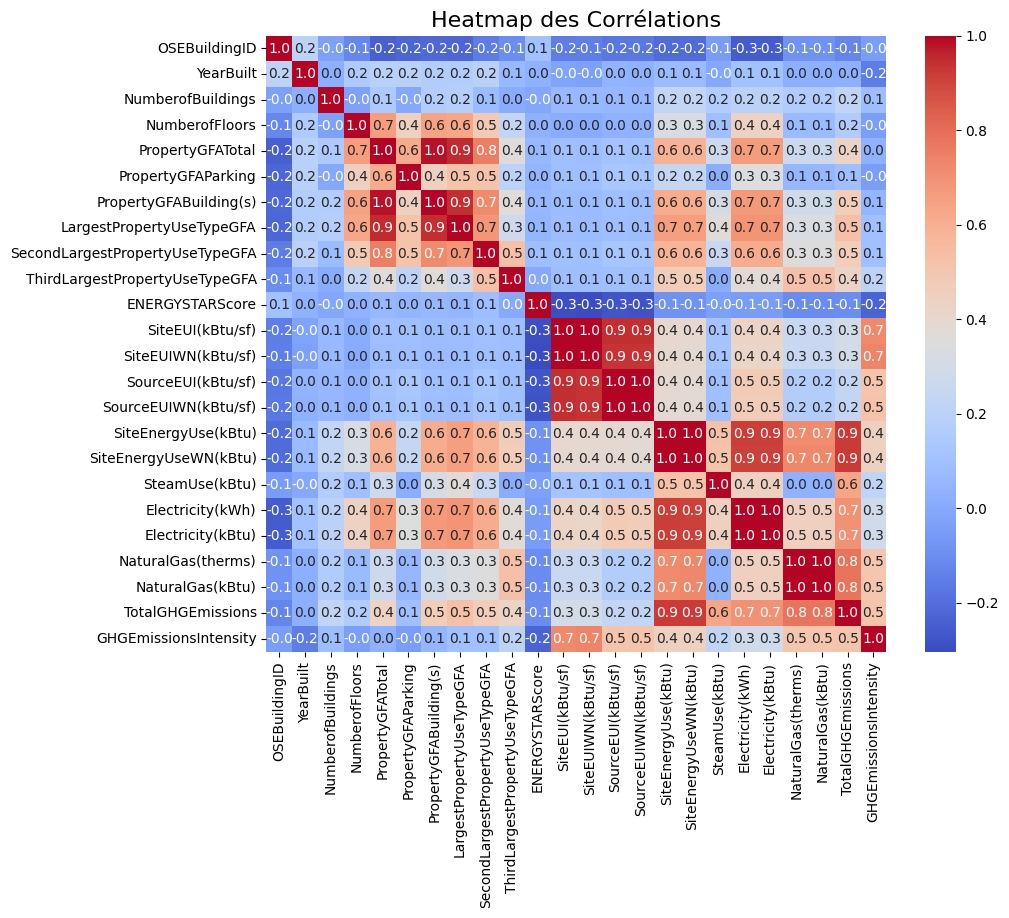

In [11]:
numeric_df = df.select_dtypes(include=[np.number])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True, 
    fmt=".1f",
    cmap="coolwarm",
)
plt.title("Heatmap des Corrélations", fontsize=16)
plt.show()

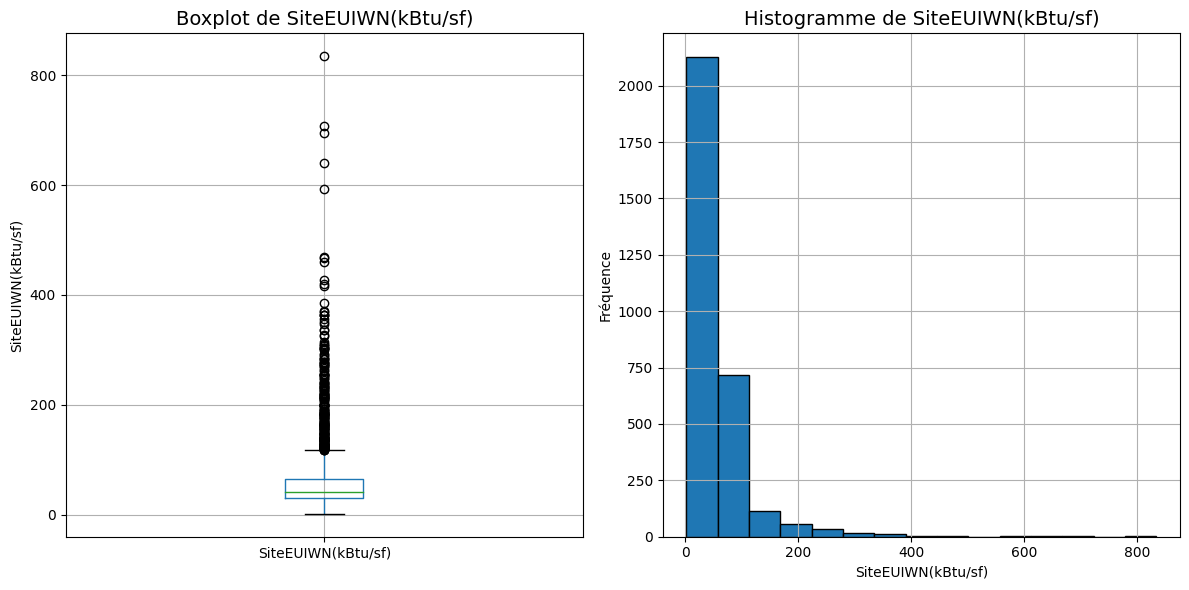

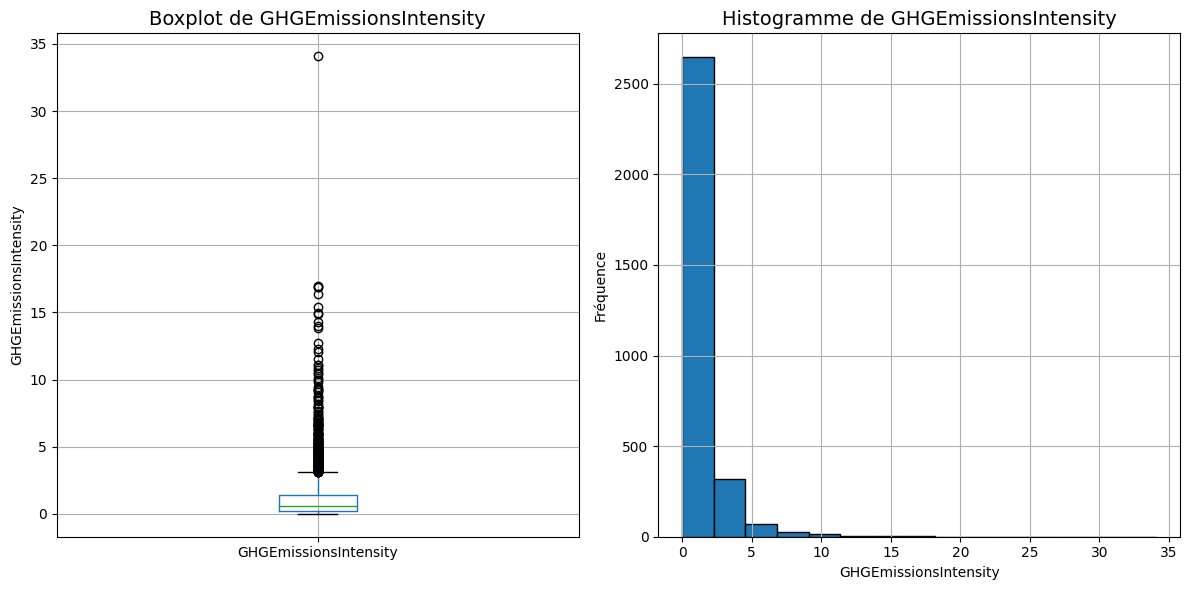

In [12]:
features = ['SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity']

for feature in features:
    plt.figure(figsize=(12, 6))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    df.boxplot(column=feature)
    plt.title(f'Boxplot de {feature}', fontsize=14)
    plt.ylabel(feature)
    
    # Histogramme
    plt.subplot(1, 2, 2)
    df[feature].hist(bins=15, edgecolor='black')
    plt.title(f'Histogramme de {feature}', fontsize=14)
    plt.xlabel(feature)
    plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()

# 1er Feature Engineering

**Filtre des bâtiments non résidentiels**

In [13]:
df = df[df['BuildingType'].str.contains('NonResidential', case=False, na=False)]

**Création d'une feature de proportion de parking**

In [14]:
df['PropertyGFAParkingPercentage'] = (df['PropertyGFAParking'] / df['PropertyGFATotal']) * 100

**Regroupement par tranche d'années de contruction**

In [15]:
bins = [0, 1950, 1970, 2000, 2025]
labels = ['Avant 1950', '1950–1970', '1970–2000', 'Apres 2000']
df['YearBuiltGroup'] = pd.cut(df['YearBuilt'], bins=bins, labels=labels)

**Taux de consommation des différentes sources d'énergie**

In [16]:
df['ElectricityProportion'] = (
    df['Electricity(kBtu)'] / df['SiteEnergyUseWN(kBtu)']
).fillna(0)
df['NaturalGasProportion'] = (
    df['NaturalGas(kBtu)'] / df['SiteEnergyUseWN(kBtu)']
).fillna(0)
df['SteamProportion'] = (
    df['SteamUse(kBtu)'] / df['SiteEnergyUseWN(kBtu)']
).fillna(0)

In [17]:
df.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'PropertyGFAParkingPercentage', 'YearBuiltGroup',
       'ElectricityProportion', 'NaturalGasProportion', 'SteamProportion'],
      dtype='object')

**Filtre des features utiles et affichage**

In [18]:
features_to_keep = [
    'BuildingType',
    'PrimaryPropertyType',
    'Neighborhood',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFAParkingPercentage',
    'YearBuiltGroup',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'LargestPropertyUseType',
    'SecondLargestPropertyUseType',
    'ThirdLargestPropertyUseType',
    'ElectricityProportion',
    'NaturalGasProportion',
    'SteamProportion',
   # 'ENERGYSTARScore'
]

df_final = df[features_to_keep]
print("Feature engineering terminé. Aperçu des données :")
display(df_final.head())

Feature engineering terminé. Aperçu des données :


,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,YearBuiltGroup,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ElectricityProportion,NaturalGasProportion,SteamProportion
0,NonResidential,Hotel,DOWNTOWN,1.0,12.0,88434.0,0.0,0.000000,Avant 1950,88434.0,0.0,0.0,Hotel,NaN,NaN,0.529177,0.171177,0.268728
1,NonResidential,Hotel,DOWNTOWN,1.0,11.0,103566.0,15064.0,14.545314,1970–2000,83880.0,15064.0,4622.0,Hotel,Parking,Restaurant,0.374270,0.593813,0.000000
2,NonResidential,Hotel,DOWNTOWN,1.0,41.0,956110.0,196718.0,20.574829,1950–1970,756493.0,0.0,0.0,Hotel,NaN,NaN,0.669849,0.020204,0.291688
3,NonResidential,Hotel,DOWNTOWN,1.0,10.0,61320.0,0.0,0.000000,Avant 1950,61320.0,0.0,0.0,Hotel,NaN,NaN,0.398590,0.260726,0.318772
4,NonResidential,Hotel,DOWNTOWN,1.0,18.0,175580.0,62000.0,35.311539,1970–2000,123445.0,68009.0,0.0,Hotel,Parking,Swimming Pool,0.366295,0.600689,0.000000


In [19]:
df_final.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ElectricityProportion,NaturalGasProportion,SteamProportion
count,1437.000000,1437.000000,1.437000e+03,1437.000000,1437.000000,1.437000e+03,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000
mean,1.066806,4.284621,1.099933e+05,14211.166319,6.737448,8.909514e+04,18755.148432,2738.859011,0.678304,0.251058,0.021100
std,0.512780,6.469372,1.879230e+05,44637.995670,14.583118,1.549632e+05,47996.033477,13122.435307,0.271521,0.240670,0.088109
min,1.000000,1.000000,1.128500e+04,0.000000,0.000000,5.656000e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,2.869600e+04,0.000000,0.000000,2.458800e+04,0.000000,0.000000,0.457970,0.000000,0.000000
50%,1.000000,2.000000,4.671000e+04,0.000000,0.000000,4.119800e+04,0.000000,0.000000,0.681696,0.215749,0.000000
75%,1.000000,4.000000,1.022350e+05,0.000000,0.000000,8.648300e+04,13540.000000,0.000000,0.957552,0.453536,0.000000
max,9.000000,76.000000,1.952220e+06,512608.000000,89.502252,1.680937e+06,441551.000000,303910.000000,1.038722,0.970778,0.647731


In [20]:
df_final.shape

(1437, 18)

In [21]:
print(df_final['BuildingType'].value_counts())

BuildingType
NonResidential        1363
Nonresidential COS      73
Nonresidential WA        1
Name: count, dtype: int64


In [22]:
df_final.isnull().sum()

BuildingType                          0
PrimaryPropertyType                   0
Neighborhood                          0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFAParkingPercentage          0
YearBuiltGroup                        0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseTypeGFA       0
ThirdLargestPropertyUseTypeGFA        0
LargestPropertyUseType                3
SecondLargestPropertyUseType        648
ThirdLargestPropertyUseType        1119
ElectricityProportion                 0
NaturalGasProportion                  0
SteamProportion                       0
dtype: int64

In [23]:
df_final.to_csv('output.csv', index=False)

In [24]:
categorical_features = [
    'PrimaryPropertyType',
    'Neighborhood',
    'YearBuiltGroup',
    'BuildingType', 
    'LargestPropertyUseType',
    'SecondLargestPropertyUseType',
    'ThirdLargestPropertyUseType'
]

onehot_encoder = OneHotEncoder(sparse=False, drop='first')
df_onehot = pd.DataFrame(onehot_encoder.fit_transform(df_final[categorical_features]), 
                         columns=onehot_encoder.get_feature_names_out(categorical_features),
                         index=df_final.index)

df_onehot_final = pd.concat([df_final.drop(columns=categorical_features), df_onehot], axis=1)

print("DataFrame après OneHotEncoding :")
display(df_onehot_final.head())

DataFrame après OneHotEncoding :


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ElectricityProportion,NaturalGasProportion,SteamProportion,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,YearBuiltGroup_1970–2000,YearBuiltGroup_Apres 2000,YearBuiltGroup_Avant 1950,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,LargestPropertyUseType_Automobile Dealership,LargestPropertyUseType_Bank Branch,LargestPropertyUseType_College/University,LargestPropertyUseType_Courthouse,LargestPropertyUseType_Data Center,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Financial Office,LargestPropertyUseType_Fire Station,LargestPropertyUseType_Fitness Center/Health Club/Gym,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Laboratory,LargestPropertyUseType_Library,LargestPropertyUseType_Lifestyle Center,LargestPropertyUseType_Manufacturing/Industrial Plant,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Movie Theater,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Museum,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Education,LargestPropertyUseType_Other - Entertainment/Public Assembly,LargestPropertyUseType_Other - Lodging/Residential,LargestPropertyUseType_Other - Mall,LargestPropertyUseType_Other - Public Services,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Restaurant/Bar,LargestPropertyUseType_Other - Services,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Performing Arts,"LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",LargestPropertyUseType_Police Station,LargestPropertyUseType_Pre-school/Daycare,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,"LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)",LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Residential Care Facility,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Worship Facility,LargestPropertyUseType_nan,SecondLargestPropertyUseType_Automobile Dealership,SecondLargestPropertyUseType_Bank Branch,SecondLargestPropertyUseType_Bar/Nightclub,SecondLargestPropertyUseType_College/University,SecondLargestPropertyUseType_Convenie

In [25]:
df_onehot_final.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ElectricityProportion,NaturalGasProportion,SteamProportion,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,YearBuiltGroup_1970–2000,YearBuiltGroup_Apres 2000,YearBuiltGroup_Avant 1950,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,LargestPropertyUseType_Automobile Dealership,LargestPropertyUseType_Bank Branch,LargestPropertyUseType_College/University,LargestPropertyUseType_Courthouse,LargestPropertyUseType_Data Center,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Financial Office,LargestPropertyUseType_Fire Station,LargestPropertyUseType_Fitness Center/Health Club/Gym,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Laboratory,LargestPropertyUseType_Library,LargestPropertyUseType_Lifestyle Center,LargestPropertyUseType_Manufacturing/Industrial Plant,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Movie Theater,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Museum,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Education,LargestPropertyUseType_Other - Entertainment/Public Assembly,LargestPropertyUseType_Other - Lodging/Residential,LargestPropertyUseType_Other - Mall,LargestPropertyUseType_Other - Public Services,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Restaurant/Bar,LargestPropertyUseType_Other - Services,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Performing Arts,"LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",LargestPropertyUseType_Police Station,LargestPropertyUseType_Pre-school/Daycare,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,"LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)",LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Residential Care Facility,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Worship Facility,LargestPropertyUseType_nan,SecondLargestPropertyUseType_Automobile Dealership,SecondLargestPropertyUseType_Bank Branch,SecondLargestPropertyUseType_Bar/Nightclub,SecondLargestPropertyUseType_College/University,SecondLargestPropertyUseType_Convenie

In [26]:
df_onehot_final.shape

(1437, 190)

In [27]:
df_onehot_final.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ElectricityProportion,NaturalGasProportion,SteamProportion,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,YearBuiltGroup_1970–2000,YearBuiltGroup_Apres 2000,YearBuiltGroup_Avant 1950,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,LargestPropertyUseType_Automobile Dealership,LargestPropertyUseType_Bank Branch,LargestPropertyUseType_College/University,LargestPropertyUseType_Courthouse,LargestPropertyUseType_Data Center,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Financial Office,LargestPropertyUseType_Fire Station,LargestPropertyUseType_Fitness Center/Health Club/Gym,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Laboratory,LargestPropertyUseType_Library,LargestPropertyUseType_Lifestyle Center,LargestPropertyUseType_Manufacturing/Industrial Plant,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Movie Theater,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Museum,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Education,LargestPropertyUseType_Other - Entertainment/Public Assembly,LargestPropertyUseType_Other - Lodging/Residential,LargestPropertyUseType_Other - Mall,LargestPropertyUseType_Other - Public Services,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Restaurant/Bar,LargestPropertyUseType_Other - Services,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Performing Arts,"LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",LargestPropertyUseType_Police Station,LargestPropertyUseType_Pre-school/Daycare,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,"LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)",LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Residential Care Facility,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Worship Facility,LargestPropertyUseType_nan,SecondLargestPropertyUseType_Automobile Dealership,SecondLargestPropertyUseType_Bank Branch,SecondLargestPropertyUseType_Bar/Nightclub,SecondLargestPropertyUseType_College/University,SecondLargestPropertyUseType_Convenie

In [28]:
df_onehot_final.to_csv('outputOHE.csv', index=False)

# Amélioration du feature engineering

**Regroupement de valeurs pour les types de propriétés**

In [29]:
property_use_mapping = {
    # Hébergement
    'Hotel': 'Hospitality',
    'Residence Hall/Dormitory': 'Hospitality',
    'Residential Care Facility': 'Hospitality',
    'Other - Lodging/Residential': 'Hospitality',

    # Commerce
    'Retail Store': 'Commercial',
    'Supermarket/Grocery Store': 'Commercial',
    'Strip Mall': 'Commercial',
    'Automobile Dealership': 'Commercial',
    'Convenience Store without Gas Station': 'Commercial',
    'Bank Branch': 'Commercial',
    'Financial Office': 'Commercial',

    # Éducation
    'K-12 School': 'Educational',
    'College/University': 'Educational',
    'Adult Education': 'Educational',
    'Other - Education': 'Educational',
    'Vocational School': 'Educational',
    'Pre-school/Daycare': 'Educational',

    # Santé
    'Hospital (General Medical & Surgical)': 'Healthcare',
    'Medical Office': 'Healthcare',
    'Urgent Care/Clinic/Other Outpatient': 'Healthcare',
    'Other/Specialty Hospital': 'Healthcare',
    'Laboratory': 'Healthcare',

    # Infrastructure
    'Parking': 'Infrastructure',
    'Self-Storage Facility': 'Infrastructure',
    'Non-Refrigerated Warehouse': 'Infrastructure',
    'Refrigerated Warehouse': 'Infrastructure',
    'Distribution Center': 'Infrastructure',
    'Fire Station': 'Infrastructure',
    'Police Station': 'Infrastructure',
    'Prison/Incarceration': 'Infrastructure',

    # Loisirs
    'Fitness Center/Health Club/Gym': 'Recreation',
    'Swimming Pool': 'Recreation',
    'Social/Meeting Hall': 'Recreation',
    'Performing Arts': 'Recreation',
    'Museum': 'Recreation',
    'Movie Theater': 'Recreation',
    'Lifestyle Center': 'Recreation',
    'Other - Entertainment/Public Assembly': 'Recreation',
    'Other - Recreation': 'Recreation',
    'Bar/Nightclub': 'Recreation',

    # Alimentation
    'Restaurant': 'FoodService',
    'Other - Restaurant/Bar': 'FoodService',
    'Fast Food Restaurant': 'FoodService',
    'Food Service': 'FoodService',
    'Food Sales': 'FoodService',

    # Secteur industriel
    'Manufacturing/Industrial Plant': 'Industrial',

    # Secteur technologique
    'Data Center': 'Technology',
    'Other - Technology/Science': 'Technology',

    # Usage mixte
    'Mixed Use Property': 'MixedUse',

    # Services religieux
    'Worship Facility': 'Religious',

    # Administration
    'Office': 'Office',
    'Large Office': 'Office',
    'Small- and Mid-Sized Office': 'Office',
    'Courthouse': 'Office',

    # Autres
    'Other': 'Other',
    'Other - Public Services': 'Other',
    'Other - Lodging/Residential': 'Other',
    'Other - Services': 'Other',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Other',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Other',
    'Other - Utility': 'Other',
    'Other/Specialty Hospital': 'Other',
    'Other - Mall': 'Other',
    'Other - Entertainment/Public Assembly': 'Other'
}

for col in ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
    df_final[col] = df_final[col].map(property_use_mapping).fillna('Other')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Encodage des proportions par type d'utilisation**

In [30]:
all_property_types = pd.unique(
    df_final[['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].values.ravel()
)

for prop_type in all_property_types:
    df_final[f'Proportion_{prop_type}'] = (
        (df_final['LargestPropertyUseType'] == prop_type) * df_final['LargestPropertyUseTypeGFA'] / df_final['PropertyGFATotal'] +
        (df_final['SecondLargestPropertyUseType'] == prop_type) * df_final['SecondLargestPropertyUseTypeGFA'] / df_final['PropertyGFATotal'] +
        (df_final['ThirdLargestPropertyUseType'] == prop_type) * df_final['ThirdLargestPropertyUseTypeGFA'] / df_final['PropertyGFATotal']
    )

df_final = df_final.drop(columns=[
    'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'
])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [31]:
df_final.head()

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,YearBuiltGroup,ElectricityProportion,NaturalGasProportion,SteamProportion,Proportion_Hospitality,Proportion_Other,Proportion_Infrastructure,Proportion_FoodService,Proportion_Recreation,Proportion_Technology,Proportion_Office,Proportion_Educational,Proportion_Commercial,Proportion_Healthcare,Proportion_Religious,Proportion_Industrial
0,NonResidential,Hotel,DOWNTOWN,1.0,12.0,88434.0,0.0,0.000000,Avant 1950,0.529177,0.171177,0.268728,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NonResidential,Hotel,DOWNTOWN,1.0,11.0,103566.0,15064.0,14.545314,1970–2000,0.374270,0.593813,0.000000,0.809918,0.0,0.145453,0.044629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NonResidential,Hotel,DOWNTOWN,1.0,41.0,956110.0,196718.0,20.574829,1950–1970,0.669849,0.020204,0.291688,0.791220,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NonResidential,Hotel,DOWNTOWN,1.0,10.0,61320.0,0.0,0.000000,Avant 1950,0.398590,0.260726,0.318772,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NonResidential,Hotel,DOWNTOWN,1.0,18.0,175580.0,62000.0,35.311539,1970–2000,0.366295,0.600689,0.000000,0.703070,0.0,0.387339,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_final.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,ElectricityProportion,NaturalGasProportion,SteamProportion,Proportion_Hospitality,Proportion_Other,Proportion_Infrastructure,Proportion_FoodService,Proportion_Recreation,Proportion_Technology,Proportion_Office,Proportion_Educational,Proportion_Commercial,Proportion_Healthcare,Proportion_Religious,Proportion_Industrial
count,1437.000000,1437.000000,1.437000e+03,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000
mean,1.066806,4.284621,1.099933e+05,14211.166319,6.737448,0.678304,0.251058,0.021100,0.056799,0.119699,0.259839,0.011522,0.033933,0.002583,0.284910,0.042583,0.109119,0.038386,0.045433,0.005056
std,0.512780,6.469372,1.879230e+05,44637.995670,14.583118,0.271521,0.240670,0.088109,0.222504,0.307150,0.420111,0.079021,0.172423,0.037116,0.375499,0.201068,0.282209,0.187869,0.209100,0.067774
min,1.000000,1.000000,1.128500e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,2.869600e+04,0.000000,0.000000,0.457970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,4.671000e+04,0.000000,0.000000,0.681696,0.215749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,1.022350e+05,0.000000,0.000000,0.957552,0.453536,0.000000,0.000000,0.000000,0.391770,0.000000,0.000000,0.000000,0.609503,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,76.000000,1.952220e+06,512608.000000,89.502252,1.038722,0.970778,0.647731,1.513747,3.437652,6.426849,1.000000,1.499970,1.000000,1.268406,1.730201,1.500000,2.697535,1.607691,1.138481


In [33]:
numerical_features = df_final.select_dtypes(include=[np.number]).columns

skewness = df_final[numerical_features].skew()

high_skew_features = skewness[abs(skewness) > 5].index
moderate_skew_features = skewness[(abs(skewness) > 0.75) & (abs(skewness) <= 5)].index  # Skewness modérée

print("\nFeatures avec skewness très élevée (> 5) :")
print(high_skew_features)

print("\nFeatures avec skewness modérée (0.75 < skewness <= 5) :")
print(moderate_skew_features)

qt = QuantileTransformer(output_distribution='normal', random_state=42)
for feature in high_skew_features:
    df_final[feature] = qt.fit_transform(df_final[[feature]])
    print(f"Transformation QuantileTransformer appliquée à {feature}")

for feature in moderate_skew_features:
    if (df_final[feature] >= 0).all():
        df_final[feature] = np.log1p(df_final[feature])
        print(f"Transformation log(1+x) appliquée à {feature}")
    else:
        print(f"Log(1+x) ignoré pour {feature} car des valeurs négatives existent.")

new_skewness = df_final[numerical_features].skew()
print("\nSkewness des features numériques après transformation :")
print(new_skewness)


Features avec skewness très élevée (> 5) :
Index(['NumberofBuildings', 'NumberofFloors', 'Proportion_FoodService',
       'Proportion_Recreation', 'Proportion_Technology',
       'Proportion_Healthcare', 'Proportion_Industrial'],
      dtype='object')

Features avec skewness modérée (0.75 < skewness <= 5) :
Index(['PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFAParkingPercentage', 'SteamProportion',
       'Proportion_Hospitality', 'Proportion_Other',
       'Proportion_Infrastructure', 'Proportion_Office',
       'Proportion_Educational', 'Proportion_Commercial',
       'Proportion_Religious'],
      dtype='object')
Transformation QuantileTransformer appliquée à NumberofBuildings
Transformation QuantileTransformer appliquée à NumberofFloors
Transformation QuantileTransformer appliquée à Proportion_FoodService
Transformation QuantileTransformer appliquée à Proportion_Recreation
Transformation QuantileTransformer appliquée à Proportion_Technology
Transformation QuantileTra

In [34]:
df_final.to_csv('outputFeatureEngineering.csv', index=False)

# Ajout de ENERGYSTARScore et de la target

In [35]:
#df_final['ENERGYSTARScore'] = df['ENERGYSTARScore']
df_final_GHG = df_final.copy()
df_final['SiteEUIWN(kBtu/sf)'] = df['SiteEUIWN(kBtu/sf)']
df_final_GHG['GHGEmissionsIntensity'] = df['GHGEmissionsIntensity']
df_final.to_csv('outputENERGYSTARScore1stTarget.csv', index=False)
df_final_GHG.to_csv('outputENERGYSTARScore2ndTarget.csv', index=False)